In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykeen
import torch

from pykeen.pipeline import pipeline

In [2]:
dataset = 'WN18RR'
num_epochs = 100
embedding_dim = 64
random_seed = 1234

edge_stalk_sizes = [1,1,1,1,1,1,1,1,1,1,1]
loss = 'SoftplusLoss'
timestr = time.strftime("%Y%m%d-%H%M")

savename = 'SheafE_nonconstant_{}epochs_{}dim_{}loss_{}seed_{}'.format(num_epochs,embedding_dim,loss,random_seed,timestr)
saveloc = os.path.join('/home/gebhart/projects/sheaf_kg/data',dataset,savename)

In [3]:
# ds = pykeen.datasets.get_dataset(dataset=dataset)

# training = ds.training.mapped_triples
# ds.training.mapped_triples = training[training[:,0].sort()[1]]
# testing = ds.testing.mapped_triples
# ds.testing.mapped_triples = testing[testing[:,0].sort()[1]]
# validation = ds.validation.mapped_triples
# ds.validation.mapped_triples = validation[validation[:,0].sort()[1]]
# ds.training.relation_id_to_label

- also_see: both restriction maps are identity
- derivationally_related_form: unconstrained on both sides, or perhaps orthogonality
- has_part: unique projection on both sides
- hypernym: unique projection on both sides
- instance_hypernym: unique projection on both sides
- member_meronym: unique projection on both sides
- member_of_domain_region: unique projection on both sides
- member_of_domain_usage: unique projection on both sides
- similar_to: some sort of minimally-distant/constrained transformation on both sides?
- synset_domain_topic_of: unique projection on both sides
- verb_group: some sort of minimally-distant/constrained transformation on both sides?

In [4]:
import functools
import itertools
from typing import Optional

from pykeen.models import StructuredEmbedding
from pykeen.models.base import EntityEmbeddingModel
from pykeen.nn import Embedding
from pykeen.losses import Loss
from pykeen.nn.init import xavier_uniform_
from pykeen.regularizers import Regularizer
from pykeen.triples import TriplesFactory
from pykeen.typing import DeviceHint
from pykeen.utils import compose

from torch.nn import functional
from torch import nn

import geotorch

class ModifiedSE(StructuredEmbedding):
    
    def __init__(
        self,
        triples_factory: TriplesFactory,
        embedding_dim: int = 40,
        edge_stalk_sizes: [int] = [40,40,20,20,20,20,20,20,40,20,40],
        alpha: float = 0.1,
        scoring_fct_norm: int = 2,
        loss: Optional[Loss] = None,
        preferred_device: DeviceHint = None,
        random_seed: Optional[int] = None,
        regularizer: Optional[Regularizer] = None,
    ) -> None:
        r"""Initialize SE.

        :param embedding_dim: The entity embedding dimension $d$. Is usually $d \in [50, 300]$.
        :param scoring_fct_norm: The $l_p$ norm. Usually 1 for SE.
        """
        super().__init__(
            triples_factory=triples_factory,
            embedding_dim=embedding_dim,
            loss=loss,
            preferred_device=preferred_device,
            random_seed=random_seed,
            regularizer=regularizer,
        )
                
        self.alpha = alpha
        self.preferred_device = preferred_device
        
        # Embeddings
        init_bound = 6 / np.sqrt(self.embedding_dim)
        
        self.left_embeddings = []
        self.right_embeddings = []
        
        # relation 1
        tsize = (edge_stalk_sizes[0],embedding_dim)
#         emb1l = nn.init.xavier_uniform_(torch.eye(tsize[0],tsize[1], device=preferred_device, requires_grad=True))
        emb1l = nn.init.xavier_uniform_(torch.eye(tsize[0],tsize[1], device=preferred_device, requires_grad=True))
        emb1r = emb1l
        self.left_embeddings.append(emb1l)
        self.right_embeddings.append(emb1r)
        
        # relation 2 
        tsize = (edge_stalk_sizes[1],embedding_dim)
        emb2l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb2r = emb2l
        self.left_embeddings.append(emb2l)
        self.right_embeddings.append(emb2r)
        
        # relation 3
        tsize = (edge_stalk_sizes[2],embedding_dim)
        emb3l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb3r = emb3l
        self.left_embeddings.append(emb3l)
        self.right_embeddings.append(emb3r)
        
        # relation 4
        tsize = (edge_stalk_sizes[3],embedding_dim)
        emb4l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb4r = emb4l
        self.left_embeddings.append(emb4l)
        self.right_embeddings.append(emb4r)
        
        # relation 5
        tsize = (edge_stalk_sizes[4],embedding_dim)
        emb5l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb5r = emb5l
        self.left_embeddings.append(emb5l)
        self.right_embeddings.append(emb5r)
        
        # relation 6
        tsize = (edge_stalk_sizes[5],embedding_dim)
        emb6l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb6r = emb6l
        self.left_embeddings.append(emb6l)
        self.right_embeddings.append(emb6r)
        
        # relation 7
        tsize = (edge_stalk_sizes[6],embedding_dim)
        emb7l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb7r = emb7l
        self.left_embeddings.append(emb7l)
        self.right_embeddings.append(emb7r)
        
        # relation 8
        tsize = (edge_stalk_sizes[7],embedding_dim)
        emb8l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb8r = emb8l
        self.left_embeddings.append(emb8l)
        self.right_embeddings.append(emb8r)
        
        # relation 9
        tsize = (edge_stalk_sizes[8],embedding_dim)
        emb9l = nn.init.xavier_uniform_(torch.eye(tsize[0],tsize[1], device=preferred_device, requires_grad=True))
        emb9r = emb9l
        self.left_embeddings.append(emb9l)
        self.right_embeddings.append(emb9r)
        
        # relation 10
        tsize = (edge_stalk_sizes[9],embedding_dim)
        emb10l = nn.init.xavier_uniform_(torch.empty(tsize, device=preferred_device, requires_grad=True))
        emb10r = emb10l
        self.left_embeddings.append(emb10l)
        self.right_embeddings.append(emb10r)
        
        # relation 11
        tsize = (edge_stalk_sizes[10],embedding_dim)
        emb11l = nn.init.xavier_uniform_(torch.eye(tsize[0],tsize[1], device=preferred_device, requires_grad=True))
        emb11r = emb11l
        self.left_embeddings.append(emb11l)
        self.right_embeddings.append(emb11r)
        
        
    def score_hrt(self, hrt_batch: torch.LongTensor) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        rel_idxs = torch.unique(hrt_batch[:,1])
        scores = torch.zeros(hrt_batch.shape[0], device=self.preferred_device)
        for i in range(rel_idxs.shape[0]):
            ix = rel_idxs[i]
            batch_indices = torch.nonzero(hrt_batch[:,1] == ix)
            batch = hrt_batch[hrt_batch[:,1] == ix]
            h = self.entity_embeddings(indices=batch[:, 0]).view(-1, self.embedding_dim, 1)
            t = self.entity_embeddings(indices=batch[:, 2]).view(-1, self.embedding_dim, 1)
            rel_h = self.left_embeddings[ix]
            rel_t = self.right_embeddings[ix]
            
            proj_h = torch.diagflat(rel_h) @ h
            proj_t = torch.diagflat(rel_t) @ t
            scores[batch_indices] = -torch.norm(proj_h - proj_t, dim=1, p=self.scoring_fct_norm)**2
            
        return scores

    def score_t(self, hr_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        rel_idxs = torch.unique(hr_batch[:,1])
        t_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)
        scores = torch.zeros((hr_batch.shape[0],t_all.shape[1]), device=self.preferred_device)
        for i in range(rel_idxs.shape[0]):
            ix = rel_idxs[i]
            batch_indices = torch.nonzero(hr_batch[:,1] == ix)
            batch = hr_batch[hr_batch[:,1] == ix]
            h = self.entity_embeddings(indices=batch[:, 0]).view(-1, self.embedding_dim, 1)
            rel_h = self.left_embeddings[ix]
            rel_t = self.right_embeddings[ix]
            rel_t = rel_t.view(-1, 1, rel_t.shape[0], rel_t.shape[1])
            
            if slice_size is not None:
                proj_t_arr = []
                # Project entities
                proj_h = rel_h @ h

                for t in torch.split(t_all, slice_size, dim=1):
                    # Project entities
                    proj_t = rel_t @ t
                    proj_t_arr.append(proj_t)
                    
                proj_t = torch.cat(proj_t_arr, dim=1)
                
            else:
                proj_h = torch.diagflat(rel_h) @ h
                proj_t = torch.diagflat(rel_t) @ t_all
                
            scores[batch_indices[:,0]] = -torch.norm(proj_h[:, None, :, 0] - proj_t[:, :, :, 0], dim=-1, p=self.scoring_fct_norm)**2
        
        return scores


    def score_h(self, rt_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        rel_idxs = torch.unique(rt_batch[:,0])
        h_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)
        scores = torch.zeros((rt_batch.shape[0],h_all.shape[1]), device=self.preferred_device)
        for i in range(rel_idxs.shape[0]):
            ix = rel_idxs[i]
            batch_indices = torch.nonzero(rt_batch[:,0] == ix)
            batch = rt_batch[rt_batch[:,0] == ix]
            t = self.entity_embeddings(indices=batch[:, 1]).view(-1, self.embedding_dim, 1)
            rel_h = self.left_embeddings[ix]
            rel_h = rel_h.view(-1, 1, rel_h.shape[0], rel_h.shape[1])
            rel_t = self.right_embeddings[ix]
            
            if slice_size is not None:
                proj_t_arr = []
                # Project entities
                proj_h = rel_h @ h

                for t in torch.split(t_all, slice_size, dim=1):
                    # Project entities
                    proj_t = rel_t @ t
                    proj_t_arr.append(proj_t)
                    
                proj_t = torch.cat(proj_t_arr, dim=1)
                
            else:
                proj_h = torch.diagflat(rel_h) @ h_all
                proj_t = torch.diagflat(rel_t) @ t

            scores[batch_indices[:,0]] = -torch.norm(proj_h[:, :, :, 0] - proj_t[:, None, :, 0], dim=-1, p=self.scoring_fct_norm)**2
        
        return scores

In [16]:
result2 = pipeline(
    model=ModifiedSE,
    dataset=dataset,
    random_seed=random_seed,
    device='gpu',
    training_kwargs=dict(num_epochs=num_epochs),
    evaluation_kwargs=dict(),
    model_kwargs=dict(embedding_dim=embedding_dim, edge_stalk_sizes=edge_stalk_sizes),
    loss=loss,
    training_loop='slcwa',
    loss_kwargs=dict()
)
model2 = result2.model
model2

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.22s seconds


ModifiedSE(
  (loss): SoftplusLoss(
    (softplus): Softplus(beta=1, threshold=20)
  )
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(40559, 64)
  )
  (left_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 4096)
  )
  (right_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 4096)
  )
)

In [6]:
transe_results = pipeline(
        dataset=dataset,
        model='TransE',
        random_seed=1235,
        device='gpu',
        training_kwargs=dict(num_epochs=num_epochs),
        model_kwargs=dict(embedding_dim=embedding_dim),
        loss='SoftplusLoss',
        training_loop='lcwa',
        loss_kwargs=dict()
    )

INFO:pykeen.training.training_loop:Starting sub_batch_size search for training now...
INFO:pykeen.training.training_loop:Concluded search with sub_batch_size 128.


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.62s seconds


In [7]:
rotate_results = pipeline(
        dataset=dataset,
        model='RotatE',
        random_seed=1235,
        device='gpu',
        training_kwargs=dict(num_epochs=num_epochs),
        model_kwargs=dict(embedding_dim=embedding_dim),
        loss='SoftplusLoss',
        training_loop='lcwa',
        loss_kwargs=dict()
    )

INFO:pykeen.training.training_loop:Starting sub_batch_size search for training now...
INFO:pykeen.training.training_loop:Concluded search with sub_batch_size 64.


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=256.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.81s seconds


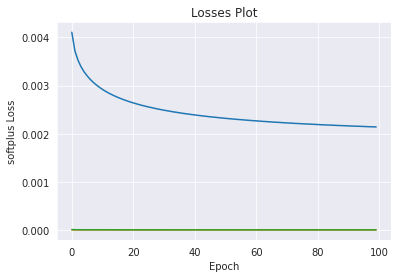

In [17]:
result2.plot_losses()
transe_results.plot_losses()
rotate_results.plot_losses()
plt.show()

In [18]:
res_df = result2.metric_results.to_df()
transe_df = transe_results.metric_results.to_df()
rotate_df = rotate_results.metric_results.to_df()
res_df['transe_diff'] = res_df.Value - transe_df.Value
res_df['rotate_diff'] = res_df.Value - rotate_df.Value

In [19]:
res_df

,Side,Type,Metric,Value,transe_diff,rotate_diff
0,head,avg,adjusted_mean_rank,0.426796,0.012295,-0.583799
1,tail,avg,adjusted_mean_rank,0.321371,0.158131,-0.414503
2,both,avg,adjusted_mean_rank,0.374084,0.085213,-0.499151
3,head,avg,mean_rank,8647.934166,246.422196,-11830.713748
4,head,avg,mean_reciprocal_rank,0.151123,0.044514,0.150379
5,head,avg,hits_at_1,0.000000,-0.004446,0.000000
6,head,avg,hits_at_3,0.292066,0.100889,0.291724
7,head,avg,hits_at_5,0.335499,0.102257,0.334815
8,head,avg,hits_at_10,0.363201,0.093707,0.361833
9,head,best,mean_rank,8647.931259,246.421683,-11830.705540


In [11]:
# res_df.to_csv(saveloc+'.csv')
# result2.save_to_directory(saveloc)